# Comparison: Clustered vs Standard Parameterization using XY mixer and Dicke Initialization
* This notebook uses local `qiskit.statevector_simulator` as the device to run k-Dicke initialized QAOA program with XY mixer comparing the Clustered and Standard Parameterizations on problems that are challenging for Vanilla QAOA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('custom')
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.problems import Knapsack, MaximumCut, NumberPartition
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *
from tqdm import tqdm

### Problem construction
* randomly initialize (or explicitly specify) a set of numbers to be partitioned
* translate the list of numbers into the QUBO form and extract the cost Hamiltonian from it
* get the exact solution of the problem by calling the `ground_state_hamiltonian` function 
* Initialize the mixer of choice to be used in the QAOA routine

In [3]:
nums=list(np.random.randint(0,200,9))
cost_prob = NumberPartition(nums).get_pubo_problem()
cost_hamil = cost_prob.hamiltonian
n_qubits = cost_hamil.n_qubits

In [4]:
#print the solution to the problem
print(ground_state_hamiltonian(cost_hamil))

(1.0, ['110011100', '001100011'])


In [6]:
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

### Construct workflow objects
* Create the QAOACircuitParams object -> responsible for the creating the abstract QAOA circuit from cost and mixer Hamiltonians
* Create and initialize the chosen Variational Parameters (for this notebook, we choose to compare Standard vs Clustered params)
* Create the backend object with prepend_states and the chosen device 

In [15]:
p=4
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=4)

In [16]:
max_std_dev=2
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev=max_std_dev)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

In [17]:
k_excitations = 3
prepend_state = dicke_wavefunction(k_excitations,n_qubits = n_qubits)
init_hadamard = False

In [18]:
device = create_device('local','qiskit.statevector_simulator')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

### Prepare the Optimizer to work with Variational Params and Backend
* specify optimization method and maxiters
* create different optimizer objects for clustered and standard params
* Perform the optimization

In [21]:
optimizer_dict = {'method': 'cobyla', 'maxiter': 2000}

In [22]:
optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
optimizer_obj_clustered = get_optimizer(backend_obj, variate_params_clustered, optimizer_dict)

In [23]:
optimizer_obj_standard
optimizer_obj_clustered

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAVectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

In [24]:
%%time
optimizer_obj_standard()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAVectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

In [25]:
%%time
optimizer_obj_clustered()

CPU times: user 10min 35s, sys: 1.58 s, total: 10min 37s
Wall time: 10min 39s


Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAVectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 2000

### Extract Results from the optimization runs
* Since this notebook compares the Clustered and Standard Parameterizations, extract the results obtained from the two optimization runs for comparison
* Plot cost history, probability overlap with low energy states, probability distribution over basis states

In [26]:
cost_history_clustered = optimizer_obj_clustered.results_information()['cost progress list']

In [27]:
cost_history_standard = optimizer_obj_standard.results_information()['cost progress list']

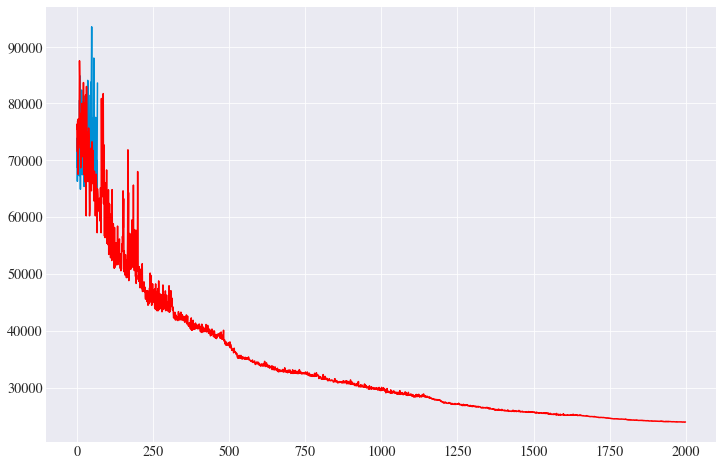

In [29]:
plt.plot(cost_history_standard,label=f'Standard Parameterization, $p={p}$',lw=0.5)
plt.plot(cost_history_clustered, color='red',label=f'Clustered Parameterization (max_std_dev={max_std_dev}), $p={p}$',lw=0.5,alpha=0.7)
# plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost Value')
plt.legend();
plt.title(f'9-qubit Number Partition Problem: {nums}, with NELDER-MEAD for maxiters=2000');
# plt.savefig(f'images/9-qubit Number Partition Problem: {nums}.pdf')

In [30]:
counts_dict_clustered = optimizer_obj_clustered.results_information()['best probability']
counts_dict_standard = optimizer_obj_standard.results_information()['best probability']

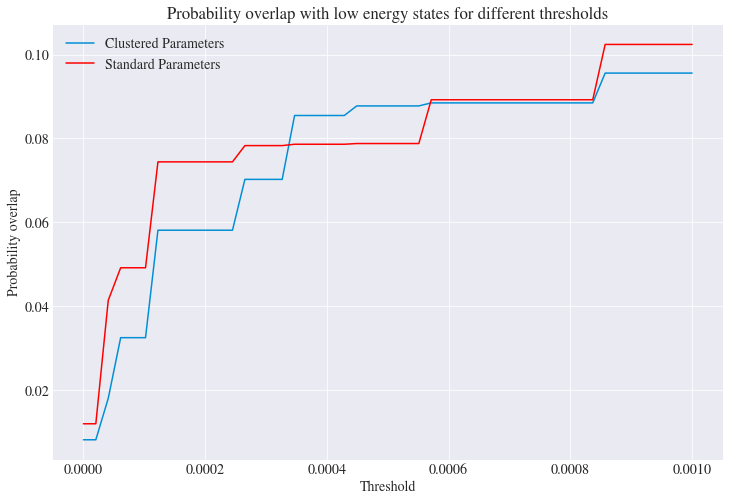

In [32]:
eps = np.linspace(0,0.001,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered) for ep in eps])
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_standard) for ep in eps],color='red')
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

In [33]:
counts_dict_standard_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_standard)
counts_dict_clustered_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_clustered)

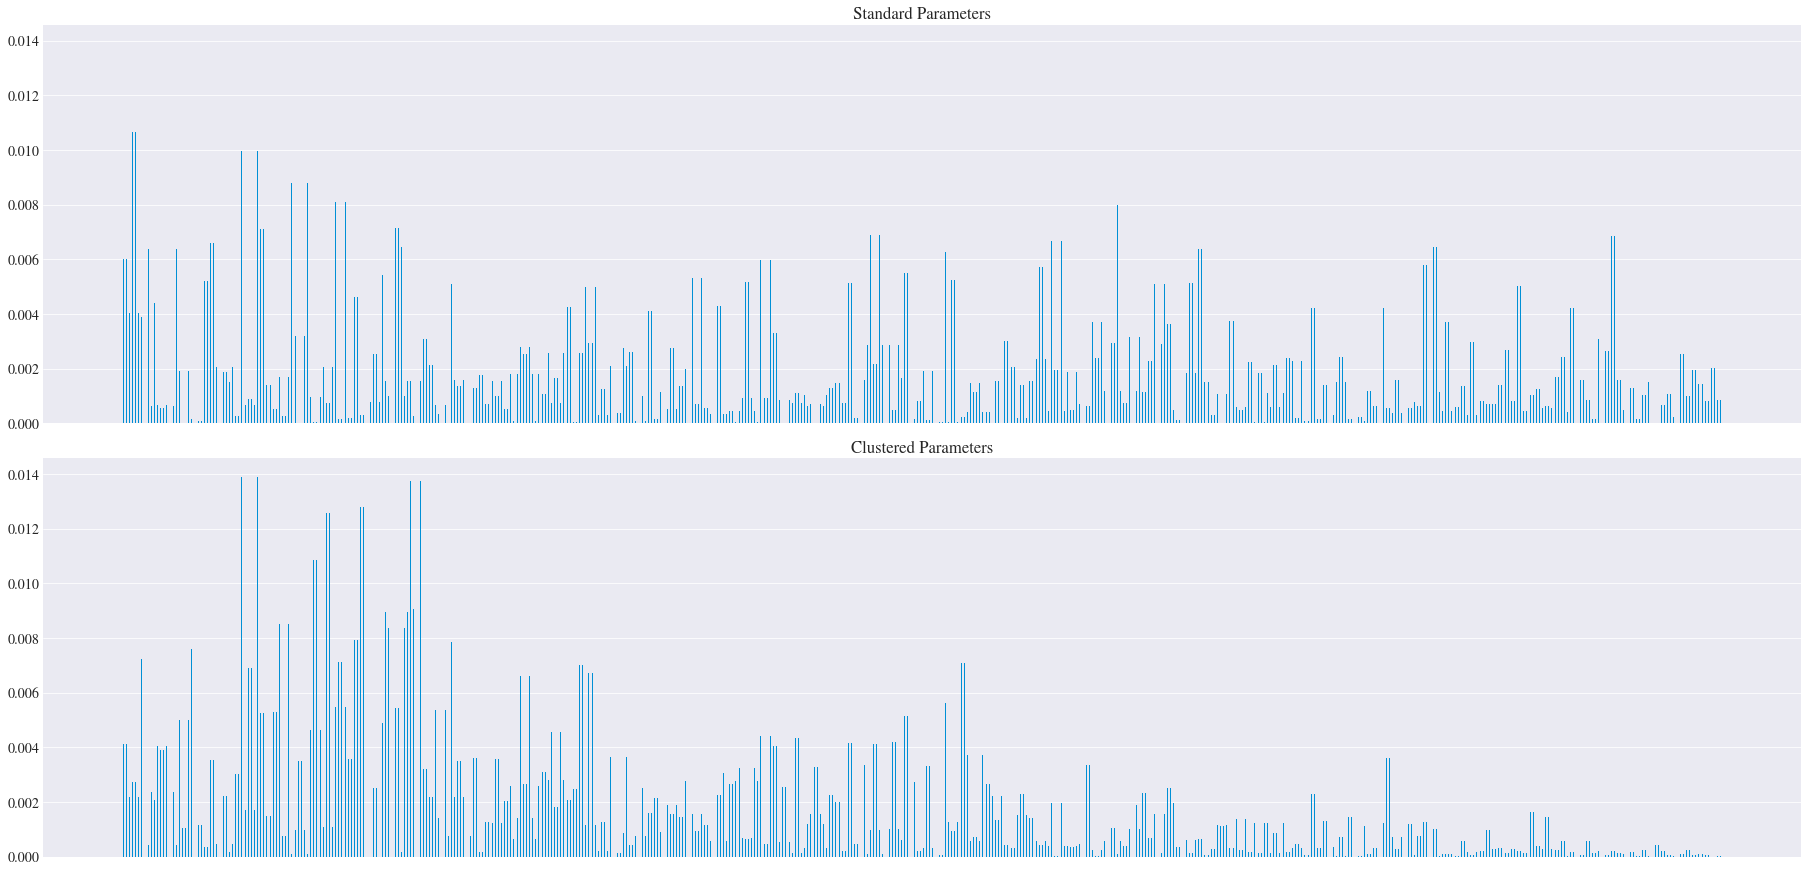

In [35]:
fig,axes = plt.subplots(2,1,figsize=(25,12),constrained_layout=True,sharey=True,sharex=True)
plot_counts(counts_dict_standard_sorted,False,axes[0])
plot_counts(counts_dict_clustered_sorted,False,axes[1])
axes[0].set_title('Standard Parameters')
axes[1].set_title('Clustered Parameters');
plt.suptitle(f'9-qubit Number Partition Problem final distribution: {nums}');
plt.ylim([0,0.09]);
# plt.savefig(f'images/9-qubit Number Partition Problem final energy distribution: {nums}.pdf')